In [1]:
import napf
import numpy as np
import scipy
import matplotlib.pyplot as plt
from generate_training_files import get_SDF
import matplotlib.cm as cm
import splinepy as sp
from scipy.optimize import least_squares
import vedo

vedo.settings.default_backend = "vtk"

In [2]:
# get the data into NumPy format
mat_data = scipy.io.loadmat('Geometries.mat')
data = mat_data['Geometries'].T.reshape(-1,1, 50, 50)
data = data.astype('float32')

In [3]:
def pixel_to_xy(image, normalized=True):
    image_width = image.shape[1]
    image_height = image.shape[2]
    coords = []
    filled = []
    for x_pixel in range(image_width):
        for y_pixel in range(image_height): 
            # Calculate the corresponding xy coordinates
            x_coord = x_pixel / (image_width) + 1/(2*image_width)
            y_coord = y_pixel / (image_height) + 1/(2*image_width)
            if normalized:
                x_coord = x_coord*2 - 1
                y_coord = y_coord*2 - 1
            coords.append(np.array([x_coord, y_coord]))
            filled.append(image[:,y_pixel, x_pixel])
    return np.array(coords), np.array(filled).astype(bool)

In [45]:
file = 56740
file = 31297
image=data[file]
SDF = get_SDF(image, normalized=False)
coords, filled =  pixel_to_xy(data[file], normalized=False)

In [46]:
def evaluate_spline(spline, points, control_points_z):
    spline.control_points[:,0] = control_points_z
    # Calculate proximities between the spline and the given points
    sp_eval = spline.evaluate(points[:,:-1])
    pts = sp_eval[:,0] - points[:,2]
    return pts


def fit_SDF(query_points,
            size_u, size_v,
            degree_u, degree_v):
    control_points = np.array([[0],
                                [0],
                                [0],
                                [0]])
    knot_vectors = np.array([[0, 0, 1, 1], [0, 0, 1, 1]])
    spline = sp.BSpline(degrees=[1, 1], control_points=control_points, knot_vectors=knot_vectors)
    spline.insert_knots(0, np.linspace(0,1,size_u+1)[1:-1])
    spline.insert_knots(1, np.linspace(0,1,size_v+1)[1:-1])
    spline.elevate_degrees([0]*(degree_u-1))
    spline.elevate_degrees([1]*(degree_v-1))
    
    approx_spline = lambda control_points_z: evaluate_spline(spline, query_points, control_points_z)

    init_guess = np.random.normal(size=spline.control_points[:,0].shape)
    result = least_squares(approx_spline, init_guess)
    spline.control_points[:,0] = result.x
    return spline

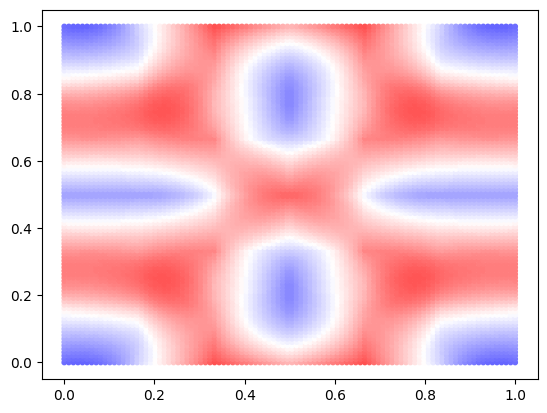

In [47]:
sp_fit = sp.BSpline()

sdf = SDF["both"]

ind = np.lexsort((sdf[:,0],sdf[:,1]))    

fitted_spline = sp_fit.approximate_surface(query_points=sdf[ind],
                                           num_points_u=50, num_points_v=50,
                                           size_u=25, size_v=25,
                                           degree_u=4, degree_v=4)

fitted_spline = fit_SDF(sdf[ind], 6, 6, 2, 2)

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
xq, yq = np.meshgrid(x,y)

spl = fitted_spline.evaluate(np.hstack([xq.reshape((-1,1)), yq.reshape((-1,1))]))
fig, ax = plt.subplots()
#
c = ax.scatter(xq.reshape((-1,1)), yq.reshape((-1,1)), c=-spl, cmap="seismic", s=10, vmin=-0.5, vmax=0.5)

C:\Users\mkofler\AppData\Local\Temp\ipykernel_10992\3383383853.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = ax.scatter(SDF["both"][:,0], SDF["both"][:,1], c=-SDF["both"][:,2], cmap=cm.get_cmap("Dark2"), s=10, vmin=-0.5, vmax=0.5)


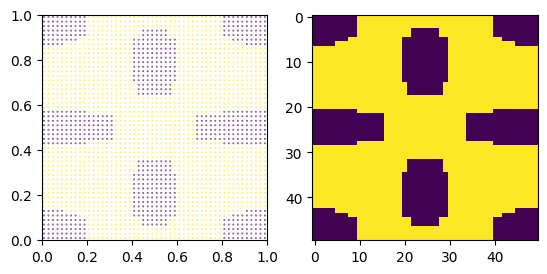

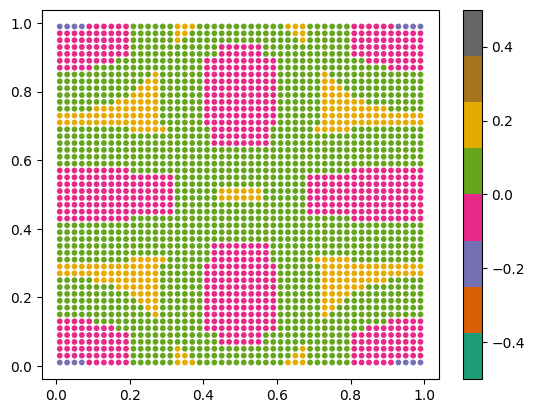

In [48]:
fig, ax = plt.subplots(1,2)


ax[0].scatter(coords[:,0], coords[:,1], c=filled, s=0.1)

ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)
ax[0].set_aspect(1)
ax[1].imshow(data[file][0])



coords, filled =  pixel_to_xy(image)

inside = coords[np.where(filled), :][0]
outside = coords[np.where(np.logical_not(filled)), :][0]


kdt_out2in = napf.KDT(inside, metric=1)
dist_out2in, ind = kdt_out2in.knn_search(outside, 1)

kdt_in2out = napf.KDT(outside, metric=1)
dist_in2out, ind = kdt_in2out.knn_search(inside, 1)
pos = np.hstack([outside, dist_out2in])
neg = np.hstack([inside, -dist_in2out])

fig, ax = plt.subplots()
c = ax.scatter(SDF["both"][:,0], SDF["both"][:,1], c=-SDF["both"][:,2], cmap=cm.get_cmap("Dark2"), s=10, vmin=-0.5, vmax=0.5)
fig.colorbar(c)

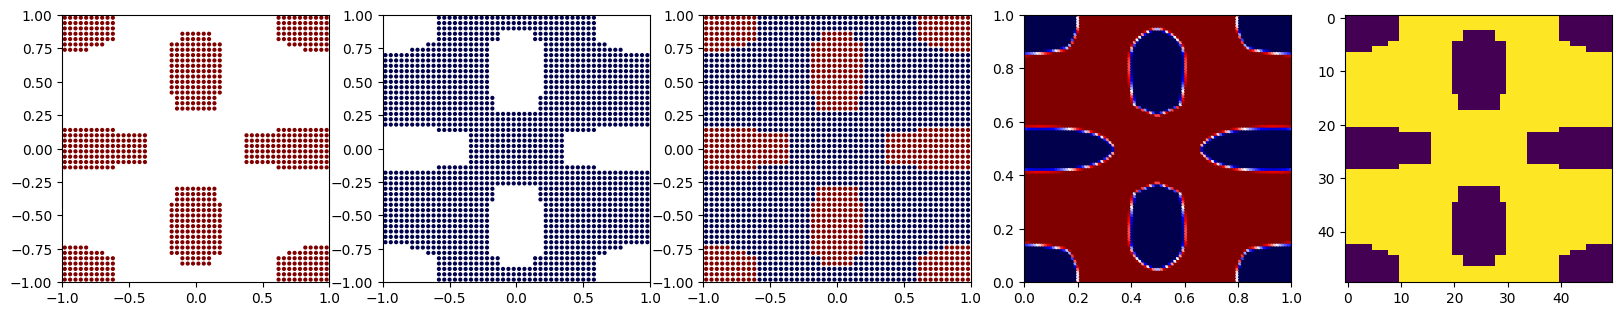

In [49]:
fig, ax = plt.subplots(1,5, figsize=(20,5))

s=4
lim = 0.01

ax[0].scatter(outside[:,0], outside[:,1], c=dist_out2in, s=s, cmap="seismic", vmin=-lim, vmax=lim)
ax[1].scatter(inside[:,0], inside[:,1], c=-dist_in2out, s=s, cmap="seismic", vmin=-lim, vmax=lim)
import matplotlib.cm as cm
ax[2].scatter(np.vstack([pos,neg])[:,0], np.vstack([pos,neg])[:,1], c=np.vstack([pos,neg])[:,2], s=s, cmap="seismic", vmin=-lim, vmax=lim)

ax[3].scatter(xq.reshape((-1,1)), yq.reshape((-1,1)), c=-spl, cmap="seismic", s=s, vmin=-lim, vmax=lim)

ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_aspect(1)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].set_aspect(1)
ax[2].set_xlim(-1,1)
ax[2].set_ylim(-1,1)
ax[2].set_aspect(1)
ax[3].set_xlim(0,1)
ax[3].set_ylim(0,1)
ax[3].set_aspect(1)
ax[4].imshow(data[file][0])

In [50]:
def bspline2p3d():
    """
    Creates new bspline of of parametric dimension 2, physical dimension 3
    """
    ds2 = [2, 2]

    # define knot vectors
    kvs2 = [
        [0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0],
        [0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
    ]

    # define control points
    cps2 = np.array(
        [
            [0, 0, 0],
            [0, 1, 0],
            [1, 1.5, 0],
            [3, 1.5, 0],
            [-1, 0, 0],
            [-1, 2, 0],
            [1, 4, 0],
            [3, 4, 0],
            [-2, 0, 0],
            [-2, 2, 0],
            [1, 5, 0],
            [3, 5, 2],
        ]
    )

    # init bspline
    return sp.BSpline(
        degrees=ds2,
        knot_vectors=kvs2,
        control_points=cps2,
    )


In [51]:
import gustaf as gus
b = bspline2p3d()
b.spline_data["me"] = fitted_spline
b.show_options["data_name"] = "me"
gus.show(["1. Show norm of coordinates.", b])

In [68]:
generator = sp.microstructure.Microstructure()
generator.deformation_function = sp.Bezier(
    degrees=[3, 1],
    control_points=[[0, 0], [1, 0], [2, -1], [3, -1], [0, 1], [1, 1], [2, 0], [3, 0]],
)

rect_tile = sp.Bezier(
    degrees=[1, 1],
    control_points=[[0, 0], [1, 0], [0, 1], [1, 1]],
)

rect_tile.spline_data["rho"] = fitted_spline 
rect_tile.show_options["data_name"] = "rho"
generator.microtile = [rect_tile]
generator.tiling = [4, 2]
ms = generator.create(macro_sensitivities=True)
ms.show()
rect_tile.show()

In [71]:
patches = []
for batch in ms.patches:
    batch.spline_data["rho"] = fitted_spline 
    batch.show_options["data_name"] = "rho"
    batch.show_options["vmin"] = -0.01
    batch.show_options["vmax"] = 0.01
    batch.show_options["cmap"] = "gray"
    batch.show_options["knots"] = False
    batch.show_options["control_points"] = False
    patches.append(batch)
gus.show(patches)